In [1]:
import sys, os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from struct_kde import (
    resample_equal_arclength,
    segment_angles,
    compute_axial_surface_intersections,
    structural_velocity,
    build_dislocation_network,
    elastic_velocity_from_segments,
)

mpl.rcParams["figure.dpi"] = 150
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "stix",
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

In [2]:
# ── Observation grid ─────────────────────────────────────────────
x_master = np.linspace(1e-3, 100.0, 1000)

# ── Fault geometry ───────────────────────────────────────────────
npts = 1000
x_dense = np.linspace(0.0, 100.0, 1000)
z_dense = -(0.005 * x_dense**2)

xnode, znode, s_uniform, L = resample_equal_arclength(x_dense, z_dense, npts)
nseg = len(xnode) - 1

# ── Slip rates ──────────────────────────────────────────────────
structuralslip = 10.0
sliprate       = 10.0

slip_fault = np.zeros(nseg, dtype=float)
n_locked = 500
slip_fault[:n_locked] = sliprate

# ── Angles & axial surfaces ─────────────────────────────────────
theta, _, _ = segment_angles(xnode, znode)
x_axial, _ = compute_axial_surface_intersections(xnode, znode, theta)

# ── Structural velocity (kinematic) ─────────────────────────────
slip_struct = structuralslip * np.ones_like(theta)
u_struct, v_struct, _ = structural_velocity(
    x_master, theta, x_axial, slip_struct, x_start=xnode[0]
)

# ── Elastic velocity (dislocation network) ──────────────────────
segments = build_dislocation_network(
    xnode=xnode,
    znode=znode,
    x_axial=x_axial,
    theta=theta,
    slip_fault=slip_fault,
    include_folds=True,
)

U1_total, U2_total, _, _ = elastic_velocity_from_segments(x_master, segments)
diff_u = u_struct - U1_total
diff_v = v_struct - U2_total

Saved: /tmp/braydennohprojects.github.io/rivers/struct_kde/struc_kde.pdf


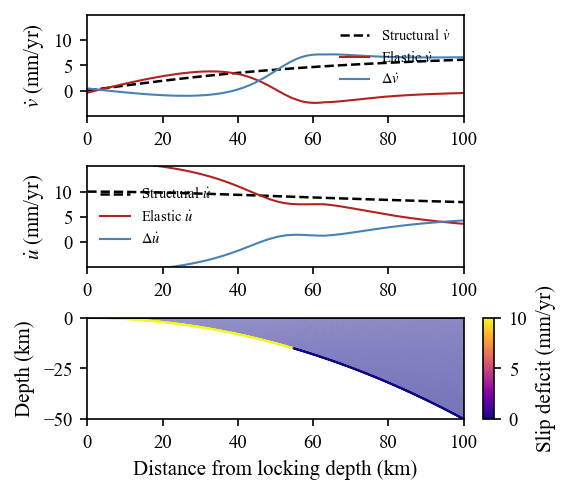

In [3]:
fig = plt.figure(figsize=(3.5, 3.5))
gs = fig.add_gridspec(
    3, 2,
    width_ratios=[1, 0.03],
    height_ratios=[1, 1, 1],
    hspace=0.5,
    wspace=0.1,
)

axV = fig.add_subplot(gs[0, 0])
axH = fig.add_subplot(gs[1, 0], sharex=axV)
axG = fig.add_subplot(gs[2, 0])
cax = fig.add_subplot(gs[2, 1])

# ── Vertical velocity ───────────────────────────────────────────
axV.plot(x_master, v_struct,  label=r"Structural $\dot{v}$", color="black", lw=1.2, ls="--")
axV.plot(x_master, U2_total,  label=r"Elastic $\dot{v}$", color="firebrick",  lw=1)
axV.plot(x_master, diff_v,    label=r"$\Delta \dot{v}$",       color="steelblue",   lw=1)
axV.set_ylabel(r"$\dot{v}$ (mm/yr)")
axV.set_ylim(-5, 15)
axV.set_yticks([0, 5, 10])
axV.legend(fontsize=7, frameon=False)

# ── Horizontal velocity ─────────────────────────────────────────
axH.plot(x_master, u_struct,  label=r"Structural $\dot{u}$", color="black", lw=1.2, ls="--")
axH.plot(x_master, U1_total,  label=r"Elastic $\dot{u}$", color="firebrick",  lw=1)
axH.plot(x_master, diff_u,    label=r"$\Delta \dot{u}$",       color="steelblue",   lw=1)
axH.set_ylabel(r"$\dot{u}$ (mm/yr)")
axH.set_ylim(-5, 15)
axH.set_yticks([0, 5, 10])
axH.legend(fontsize=7, frameon=False)

# ── Fault geometry ──────────────────────────────────────────────
segs_xy = np.array(
    [[[s["x1"], s["z1"]], [s["x2"], s["z2"]]] for s in segments],
    dtype=float,
)
slips = np.array([s["slip"] for s in segments], dtype=float)
kinds = np.array([s["kind"] for s in segments])

mask_fault = kinds == "fault"
mask_axial = kinds == "fold"

norm = TwoSlopeNorm(vmin=0.0, vcenter=0.5 * structuralslip, vmax=structuralslip)

lc_fault = LineCollection(segs_xy[mask_fault], cmap=plt.cm.plasma, norm=norm, zorder=1)
lc_fault.set_array(slips[mask_fault])
lc_fault.set_linewidths(1)
lc_fault.set_capstyle("round")
axG.add_collection(lc_fault)

lc_axial = LineCollection(segs_xy[mask_axial], cmap=plt.cm.plasma, norm=norm, zorder=0)
lc_axial.set_array(slips[mask_axial])
lc_axial.set_linewidths(0.1)
lc_axial.set_capstyle("round")
axG.add_collection(lc_axial)

axG.axhline(0, color="k", lw=0.8)
axG.set_xlabel("Distance from locking depth (km)")
axG.set_ylabel("Depth (km)")
axG.set_xlim(0, 100)
axG.set_ylim(-50, 0)

xlim = axG.get_xlim()
axV.set_xlim(xlim)
axH.set_xlim(xlim)

sm = ScalarMappable(norm=norm, cmap=plt.cm.plasma)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Slip deficit (mm/yr)")
cbar.set_ticks([0.0, 0.5 * structuralslip, structuralslip])

for ax in [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]:
    ax.axis("off")

outpath = "/tmp/braydennohprojects.github.io/rivers/struct_kde/struc_kde.pdf"
fig.savefig(outpath, bbox_inches="tight")
print(f"Saved: {outpath}")
plt.show()